<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/elegy_high_level_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Elegy

This is slightly modified from 
https://poets-ai.github.io/elegy/getting-started/high-level-api/




In this tutorial we will explore the basic features of **Elegy**. If you are a Keras user you should feel at home, if you are currently learning JAX things will appear much more streamlined. To get started you will first need to install the following dependencies:

In [1]:

!pip install git+https://github.com/deepmind/dm-haiku
!pip install -q clu ml-collections git+https://github.com/google/flax

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-pxv96o59
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-pxv96o59
  Created wheel for dm-haiku: filename=dm_haiku-0.0.6.dev0-py3-none-any.whl size=537934 sha256=a5191cab107b452a9055a84a076ad6de407858a47cfdd2f7c53873da0660ec6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wbnmk2q2/wheels/06/28/69/ebaac5b2435641427299f29d88d005fb4e2627f4a108f0bdbc
Successfully built dm-haiku
     |████████████████████████████████| 77 kB 3.6 MB/s 
     |████████████████████████████████| 88 kB 8.7 MB/s 
     |████████████████████████████████| 118 kB 57.9 MB/s 
     |████████████████████████████████| 57 kB 6.7 MB/s 


In [2]:
! pip install --upgrade pip
! pip install elegy datasets matplotlib
# For GPU install proper version of your CUDA, following will work in colab:
# ! pip install --upgrade jax jaxlib -f https://storage.googleapis.com/jax-releases/jax_releases.html

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 69 kB 3.8 MB/s             
     |████████████████████████████████| 290 kB 10.4 MB/s            
     |████████████████████████████████| 124 kB 88.7 MB/s            
     |████████████████████████████████| 104 kB 91.9 MB/s            
     |████████████████████████████████| 243 kB 82.2 MB/s            
     |████████████████████████████████| 59 kB 9.1 MB/s             
     |████████████████████████████████| 1.1 MB 77.2 MB/s            
     |████████████████████████████████| 132 kB 92.7 MB/s            
     |████████████████████████████████| 636 kB 77.8 MB/s            
     |████████████████████████████████| 213 kB 84.7 MB/s            
     |████████████████████████████████| 160 kB 81.0 MB/s            
     |████████████████████████████████| 271

**Note:** that Elegy depends on the jax CPU version hosted on Pypi, if you want to run jax on GPU you will need to [install it](https://github.com/google/jax#installation) separately. If you are running this example on colab, JAX is already preinstalled but you can uncomment the last line of the previous cell if you want to update it.

## Loading the Data
In this tutorial we will train a Neural Network on the MNIST dataset, for this we will first need to download and load the data into memory. Here we will use the `datasets` library to load the dataset.

In [ ]:
from datasets.load import load_dataset

dataset = load_dataset("cifar10")
dataset.set_format("np")
print(dataset)

Reusing dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/951e017399fa3b30edfca56468a91ac6a03c9167c0b3f79367e777d1f9a0cf7e)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})


In [3]:
from datasets.load import load_dataset

dataset = load_dataset("mnist")
dataset.set_format("np")
X_train = dataset["train"]["image"]
y_train = dataset["train"]["label"]
X_test = dataset["test"]["image"]
y_test = dataset["test"]["label"]

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/989 [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/9.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset mnist downloaded and prepared to /root/.cache/huggingface/datasets/mnist/mnist/1.0.0/5064c25e57a1678f700d2dc798ffe8a6d519405cca7d33670fffda477857a994. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

X_train: (60000, 28, 28) int64
y_train: (60000,) int64
X_test: (10000, 28, 28) int64
y_test: (10000,) int64


## Defining the Architecture
The first thing we need to do is define our model's architecture inside a `Module`, to do this we just create a class that inherites from `Module` and implement a `__call__` method. In this example we will create a simple 2 layer MLP: 

In [4]:
import jax.numpy as jnp
import jax

import elegy as eg

class MLP(eg.Module):
    def __init__(self, n1: int, n2: int):
        self.n1 = n1
        self.n2 = n2
    
    @eg.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x = x.astype(jnp.float32) / 255.0
        x = eg.nn.Flatten()(x)
        # first layers
        x = eg.nn.Linear(self.n1)(x)
        x = jax.nn.relu(x)
        # first layers
        x = eg.nn.Linear(self.n2)(x)
        x = jax.nn.relu(x)
        # output layer
        x = eg.nn.Linear(10)(x)
        
        return x

This code should feel familiar to most Keras / PyTorch users, the main difference is that we are using the `@compact` decorator to define submodules inline (e.g. Linear) inline, this tends to produce much shorter and readable code.

## Creating the Model

Now that we have this module we can create an Elegy `Model` which is Elegy's central API:

In [5]:
import optax

model = eg.Model(
    module=MLP(n1=300, n2=100),
    loss=[
        eg.losses.Crossentropy(),
        eg.regularizers.L2(l=1e-4),
    ],
    metrics=eg.metrics.Accuracy(),
    optimizer=optax.adam(1e-3),
)

If you are a Keras user this code should look familiar, main differences are:

* You need to pass a `module` with the architecture.
* `loss` and `metrics` are a bit more flexible in that they do not need to match the label's structure.
* There is no `compile` step, all its done in the constructor.
* For the `optimizer` you can use any `optax` optimizer. 

As in Keras, you can get a rich description of the model by calling `Model.summary` with a sample input:

In [6]:
model.summary(X_train[:64])

┏━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path     ┃ module    ┃ params         ┃ inputs         ┃ outputs        ┃ Parameter       ┃
┡━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ *        │ MLP()     │                │ (64, 28, 28)   │ (64, 10)       │                 │
│          │           │                │ int32          │ float32        │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .flatten │ Flatten() │                │ (64, 28, 28)   │ (64, 784)      │                 │
│          │           │                │ float32        │ float32        │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear  │ Linear()  │ bias:          │ (64, 784)      │ (64, 300)      │ 235,500         │
│          │           │ Parameter(300) │ float32        │ float32        │ 942.0KB         │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(784, │                │                │                 │
│          │           │ 300)  float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear2 │ Linear()  │ bias:          │ (64, 300)      │ (64, 100)      │ 30,100          │
│          │           │ Parameter(100) │ float32        │ float32        │ 120.4KB         │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(300, │                │                │                 │
│          │           │ 100)  float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ .linear3 │ Linear()  │ bias:          │ (64, 100)      │ (64, 10)       │ 1,010    4.0KB  │
│          │           │ Parameter(10)  │ float32        │ float32        │                 │
│          │           │ float32        │                │                │                 │
│          │           │ kernel:        │                │                │                 │
│          │           │ Parameter(100, │                │                │                 │
│          │           │ 10)   float32  │                │                │                 │
├──────────┼───────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│          │           │                │                │         Total: │ 266,610  1.1MB  │
└──────────┴───────────┴────────────────┴────────────────┴────────────────┴─────────────────┘
                                                                                             
                              Total Parameters: 266,610  1.1MB                               

## Training the Model
We are now ready to pass our model some data to start training, like in Keras this is done via the `fit` method which contains more or less the same signature. Elegy support a variety of input data sources like Tensorflow Dataset, Pytorch DataLoader, Elegy DataLoader, and Python Generators, check out the guide on Data Sources for more information. 

The following code will train our model for `100` epochs while limiting each epoch to `200` steps and using a batch size of `64`:

In [7]:
history = model.fit(
    inputs=X_train,
    labels=y_train,
    epochs=10,
    steps_per_epoch=200,
    batch_size=64,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[eg.callbacks.ModelCheckpoint("models/high-level", save_best_only=True)],
)

Epoch 1/10
200/200 [==============================] - 6s 28ms/step - accuracy: 0.7476 - crossentropy_loss: 0.8659 - l2_loss: 0.0359 - loss: 0.9018 - val_accuracy: 0.9268 - val_crossentropy_loss: 0.2502 - val_l2_loss: 0.0363 - val_loss: 0.2864
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9340 - crossentropy_loss: 0.2268 - l2_loss: 0.0376 - loss: 0.2644 - val_accuracy: 0.9423 - val_crossentropy_loss: 0.1896 - val_l2_loss: 0.0387 - val_loss: 0.2284
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9475 - crossentropy_loss: 0.1786 - l2_loss: 0.0397 - loss: 0.2183 - val_accuracy: 0.9443 - val_crossentropy_loss: 0.1736 - val_l2_loss: 0.0405 - val_loss: 0.2141
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - accuracy: 0.9549 - crossentropy_loss: 0.1583 - l2_loss: 0.0413 - loss: 0.1996 - val_accuracy: 0.9639 - val_crossentropy_loss: 0.1251 - val_l2_loss: 0.0420 - val_loss: 0.1670
Epoch 5/10
199/200 [===========

The `ModelCheckpoint` callback will periodically save the model in a folder called `"models/high-level"`, we will use it later.

`fit` returns a `History` object which of the losses and metrics during training which we can visualize.

## Plotting learning curves

In [14]:
print(history)
print(history.history)

{'accuracy': [DeviceArray(0.8567187, dtype=float32), DeviceArray(0.93398434, dtype=float32), DeviceArray(0.9475, dtype=float32), DeviceArray(0.95492184, dtype=float32), DeviceArray(0.96058416, dtype=float32), DeviceArray(0.96921873, dtype=float32), DeviceArray(0.97085935, dtype=float32), DeviceArray(0.96968746, dtype=float32), DeviceArray(0.97101563, dtype=float32), DeviceArray(0.97526693, dtype=float32)], 'crossentropy_loss': [DeviceArray(0.5012411, dtype=float32), DeviceArray(0.22684513, dtype=float32), DeviceArray(0.1785875, dtype=float32), DeviceArray(0.1583402, dtype=float32), DeviceArray(0.13318515, dtype=float32), DeviceArray(0.10116718, dtype=float32), DeviceArray(0.10102269, dtype=float32), DeviceArray(0.09987427, dtype=float32), DeviceArray(0.093276, dtype=float32), DeviceArray(0.0772732, dtype=float32)], 'l2_loss': [DeviceArray(0.03549223, dtype=float32), DeviceArray(0.03758113, dtype=float32), DeviceArray(0.03974415, dtype=float32), DeviceArray(0.04130895, dtype=float32), D

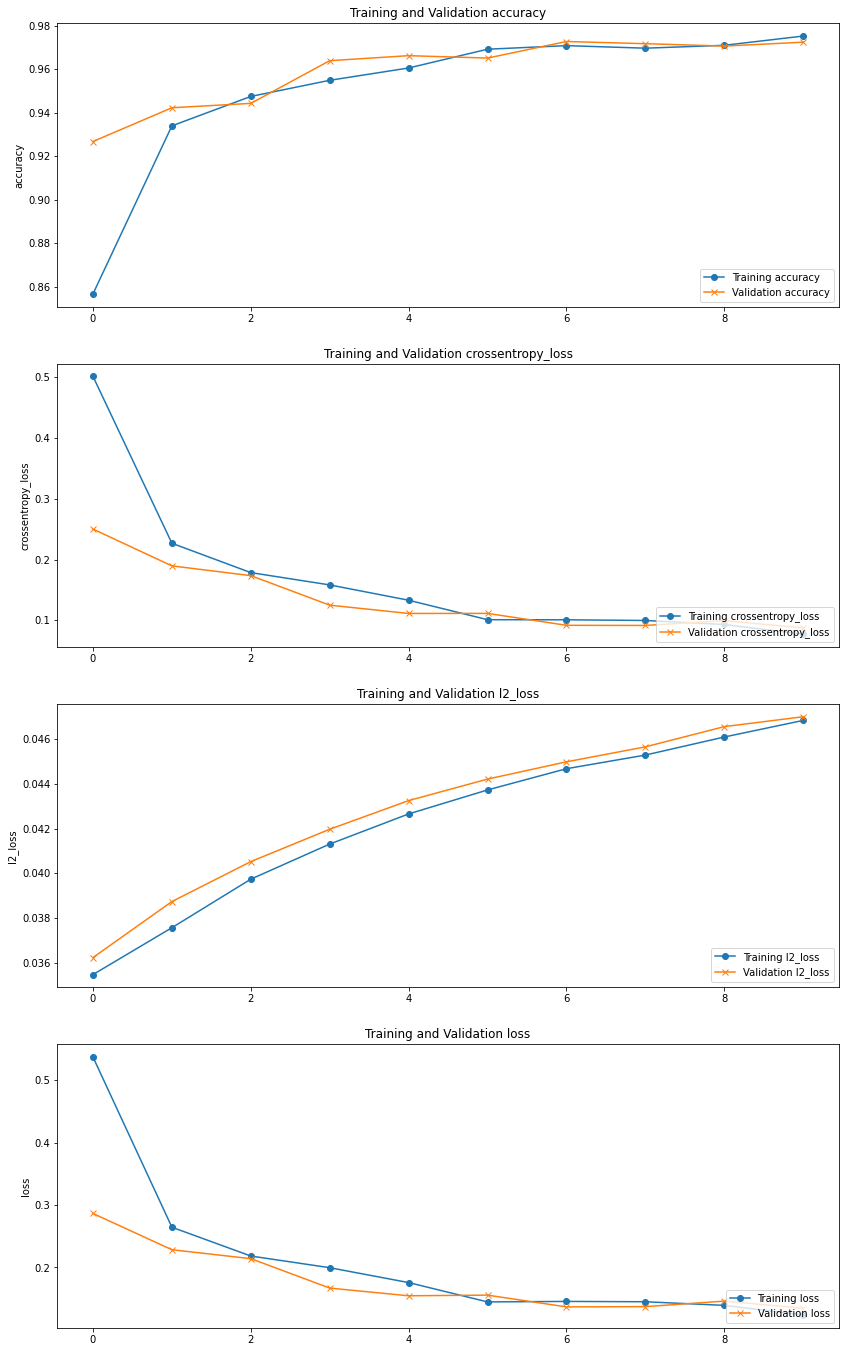

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    n_plots = len(history.history.keys()) // 2
    plt.figure(figsize=(14, 24))
    
    for i, key in enumerate(list(history.history.keys())[:n_plots]):
        metric = history.history[key]
        val_metric = history.history[f"val_{key}"]

        plt.subplot(n_plots, 1, i + 1)
        plt.plot(metric, 'o-', label=f"Training {key}")
        plt.plot(val_metric, 'x-', label=f"Validation {key}")
        plt.legend(loc="lower right")
        plt.ylabel(key)
        plt.title(f"Training and Validation {key}")
    plt.show()
    
plot_history(history)

## Generating Predictions

Having our trained model we can now get some samples from the test set and generate some predictions. Lets select `9` random images and call `.predict`:

In [17]:
import numpy as np

idxs = np.random.randint(0, len(X_test), size=(9,))
x_sample = X_test[idxs]

y_pred = model.predict(x=x_sample)

In [19]:
print(y_pred.shape)

(9, 10)


Easy right? Finally lets plot the results to see if they are accurate.

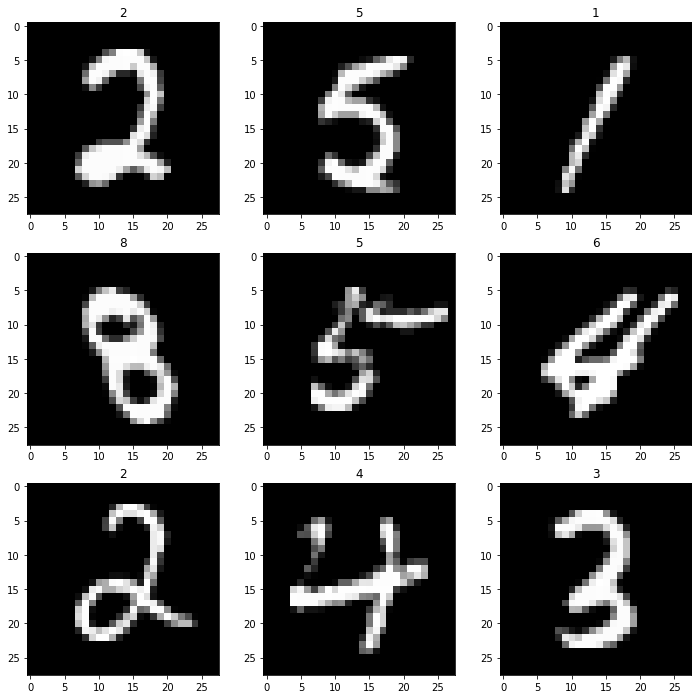

In [18]:
plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred[k])}")
        plt.imshow(x_sample[k], cmap="gray")



## Serialization
To serialize the `Model` you can use the `model.save(...)`, this will create a folder with some files that contain the model's code plus all parameters and states.

In [21]:
model.save("mymodel")

In [22]:
!ls

models	mymodel  sample_data


In [23]:
!ls mymodel

model.pkl




However since we had previously used the `ModelCheckpoint` callback we can load it using `elegy.load`. Lets get a new model reference containing the same weights and call its `evaluate` method to verify it loaded correctly:

In [24]:
!ls models

high-level


In [25]:
!ls models/high-level

model.pkl


In [20]:


# current model reference
print("current model id:", id(model))

model.evaluate(x=X_test, y=y_test)

model_old = model

# load model from disk
model = eg.load("models/high-level")

# new model reference
print("new model id:    ", id(model))

# check that it works!
model.evaluate(x=X_test, y=y_test)

current model id: 140609660799184
313/313 [==============================] - 3s 8ms/step - accuracy: 0.9696 - crossentropy_loss: 0.0992 - l2_loss: 0.0470 - loss: 0.1462
new model id:     140611931634448
313/313 [==============================] - 2s 7ms/step - accuracy: 0.9696 - crossentropy_loss: 0.0992 - l2_loss: 0.0470 - loss: 0.1462


{'accuracy': DeviceArray(0.9725, dtype=float32),
 'crossentropy_loss': DeviceArray(0.08743361, dtype=float32),
 'l2_loss': DeviceArray(0.04698371, dtype=float32),
 'loss': DeviceArray(0.13441733, dtype=float32),
 'size': 32}

You can also serialize your Elegy Model as a TensorFlow SavedModel which is portable to many platforms and services by using the `saved_model` method with a sample input and the output path:

In [26]:
model.saved_model(x_sample, "saved-models/high-level")

INFO:tensorflow:Assets written to: saved-models/high-level/assets


INFO:tensorflow:Assets written to: saved-models/high-level/assets


In [28]:
!ls saved-models/high-level

assets	saved_model.pb	variables


We can test our saved model by loading it with TensorFlow and generating a couple of predictions as we did previously:

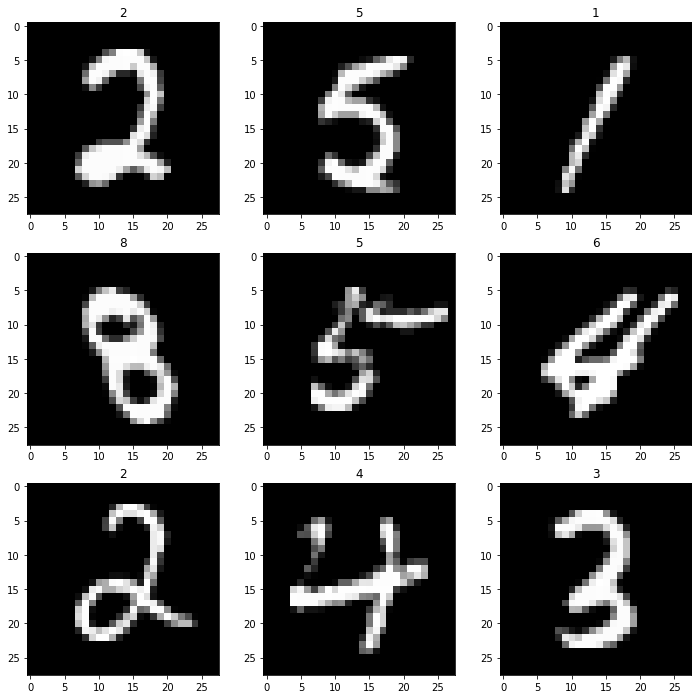

In [29]:
import tensorflow as tf

saved_model = tf.saved_model.load("saved-models/high-level")

y_pred_tf = saved_model(x_sample.astype(np.int32))

plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        plt.subplot(3, 3, k + 1)
    
        plt.title(f"{np.argmax(y_pred_tf[k])}")
        plt.imshow(x_sample[k], cmap="gray")